In [2]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.fasta import FASTAFile
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score, completeness_score
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess

%load_ext autoreload
%autoreload 2


In [ ]:
genome_metadata_df = pd.read_csv('../data/ar53_metadata_r226.tsv', sep='\t')
genome_metadata_df.accession = [genome_id.replace('RS_','').replace('GB_', '') for genome_id in genome_metadata_df.accession]

pyl_genome_metadata_df = pd.read_csv('../data/kivenson_2023_table_2.csv')
pyl_genome_ids = pyl_genome_metadata_df['Assembly Accession'].tolist()
pyl_genome_ids = pyl_genome_ids + [genome_id.replace('GCA', 'GCF') for genome_id in pyl_genome_ids]
genome_metadata_df['pyl'] = genome_metadata_df.accession.isin(pyl_genome_ids)

rep_genome_ids = genome_metadata_df.gtdb_genome_representative.unique()
rep_genome_ids = [genome_id.replace('RS_','').replace('GB_', '') for genome_id in rep_genome_ids]

# Download the GTDB representative and the ones with data in the paper.
genome_ids = rep_genome_ids + pyl_genome_ids
# downloader = NCBI()
# downloader.get_genomes(genome_ids)
extract()


In [108]:

genome_metadata_df = genome_metadata_df[genome_metadata_df.accession.isin(genome_ids)].copy() # Filter for the representatives.

downloaded_genome_ids = [file_name.replace('.fa', '') for file_name in os.listdir('../data/ncbi/proteins/')]
genome_metadata_df = genome_metadata_df[genome_metadata_df.accession.isin(downloaded_genome_ids)]
genome_metadata_df = genome_metadata_df.set_index('accession')

In [7]:
for path in tqdm(glob.glob('../data/ncbi/genomes/*')[::-1], 'Running Prodigal with default code on Archaeal genomes.'):
    output_path = os.path.basename(path).replace('.fn', '.fa')
    output_path = os.path.join('../data/prodigal', output_path)
    if not os.path.exists(output_path):
        subprocess.run(f'prodigal -i {path} -a {output_path}', shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

Running Prodigal with default code on Archaeal genomes.: 100%|██████████| 7440/7440 [3:39:07<00:00,  1.77s/it]     


In [ ]:
# for path in tqdm(glob.glob('../data/ncbi/genomes/*'), 'Running Prodigal with default code on Archaeal genomes.'):
#     output_path = os.path.basename(path).replace('.fn', '.fa')
#     output_path = os.path.join('../data/prodigal', output_path)
#     subprocess.run(f'prodigal -i {path} -a {output_path}', shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

for path in tqdm(glob.glob('../data/prodigal/*'), 'Running HMM search on Prodigal outputs.'):
    output_path = os.path.basename(path).replace('.fa', '.tab')
    output_path = os.path.join('../data/hmmer', output_path)
    if not os.path.exists(output_path):
        subprocess.run(f'hmmsearch --tblout {output_path} ../data/arf1.hmm {path}', shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

Running HMM search on Prodigal outputs.:   0%|          | 0/159 [00:00<?, ?it/s]

Running HMM search on Prodigal outputs.: 100%|██████████| 159/159 [00:07<00:00, 21.08it/s]


In [1]:
# def get_arf1(path:str):
#     df = FASTAFile(path).to_df()
#     df = df[df.description.str.contains('aRF-1')].copy()
#     df['genome_id'] = os.path.basename(path).replace('.fa', '')
#     return df 

# # Why doesn't every genome have a release factors?
# if not os.path.exists('../data/arf1.csv'):
#     arf1_df = [get_arf1(path) for path in tqdm(glob.glob('../data/ncbi/proteins/*'), desc='Collecting aRF-1 data.')]
#     arf1_df = pd.concat(arf1_df)
#     arf1_df.to_csv('../data/arf1.csv')
# else:
#     arf1_df = pd.read_csv('../data/arf1.csv', index_col=0)

# arf1_df = arf1_df[~arf1_df.index.duplicated()].copy() # Drop duplicate indices.
# genome_metadata_df['arf1'] = genome_metadata_df.index.isin(arf1_df.genome_id)

# arf1_df['pyl'] = arf1_df.genome_id.map(genome_metadata_df.pyl)
# arf1_df['category_1'] = arf1_df.genome_id.map(genome_metadata_df.category_1)
# arf1_df['length'] = arf1_df.seq.apply(len)

In [99]:
# To make the MSA more tractable, going to subsample the aRF-1 sequences. Or perhaps try clustering first. 
# Do the release factors cluster together?

# Clustered at 50% identity. 
arf1_cluster_df = pd.read_csv('../data/arf1_cluster.tsv', sep='\t', names=['rep_id', 'id'])
arf1_cluster_df['genome_id'] = arf1_cluster_df['id'].map(arf1_df.genome_id)
arf1_cluster_df['category_1'] = arf1_cluster_df.genome_id.map(genome_metadata_df.category_1)
arf1_cluster_df['pyl'] = arf1_cluster_df['id'].map(arf1_df.pyl)
print('Num. clusters:', arf1_cluster_df.rep_id.nunique(), end='\n\n')

interesting_arf1_rep_ids = list()
for rep_id, df in arf1_cluster_df.groupby('rep_id'):
    if np.any(df.pyl != df.pyl.iloc[0]):
        print(f'Cluster {rep_id} size:', len(df))
        interesting_arf1_rep_ids.append(rep_id)

# There are six clusters where there are organisms that do and don't use Pyl. 

Num. clusters: 1086

Cluster MDC7950810.1 size: 4
Cluster MDR3206199.1 size: 11
Cluster MDY0266392.1 size: 13
Cluster UAL07510.1 size: 3
Cluster WP_233084333.1 size: 13
Cluster WP_324445400.1 size: 26
Cluster WP_371854464.1 size: 28


In [100]:
rep_id = 'WP_371854464.1'
cluster_ids = arf1_cluster_df[arf1_cluster_df.rep_id == rep_id]['id'].values
df = arf1_df.loc[cluster_ids].copy()
FASTAFile(df=df).write(f'../data/{rep_id}_cluster.fa')

print('Num. Pyl-using in cluster:', cluster_arf1_df.pyl.sum())
print('Num. non-Pyl-using in cluster:', (~cluster_arf1_df.pyl).sum())


dayhoff6 = {aa: grp for grp, aas in zip('abcdef', [['C'], ['A','G','P','S','T'], ['D','E','N','Q'], ['H','K','R'], ['I','L','M','V'], ['F','W','Y']]) for aa in aas}

def load_alignment(path:str=f'../data/{rep_id}_cluster.afa', alphabet=dayhoff6):
    df = FASTAFile(path=path).to_df()
    index = df.index.values
    alignment = [list(seq) for seq in df.seq]

    if alphabet is not None:
        alignment = [[alphabet.get(aa, '-') for aa in row] for row in alignment]

    return index, np.array(alignment)

index, alignment = load_alignment(alphabet=None)
groups = np.array([arf1_df.loc[id_].pyl for id_ in index])

Num. Pyl-using in cluster: 22
Num. non-Pyl-using in cluster: 6


In [104]:
arf1_cluster_df[~arf1_cluster_df.category_1.isnull()]

,rep_id,id,genome_id,category_1,pyl
1104,WP_042686727.1,WP_042686727.1,GCF_000711905.1,1.08,True
1466,MDR3206199.1,MDR3282945.1,GCA_031290095.1,43.75,True
1471,MDR3206199.1,MDR1404337.1,GCA_031267895.1,65.38,True
1569,WP_013193507.1,WP_292486895.1,GCF_018609725.1,26.47,True
1587,MCP8322823.1,MCP8322823.1,GCA_024256165.1,1.14,True
1750,UAL07510.1,UAL07510.1,GCA_019262145.1,36.36,True
1756,MDY0266392.1,MCL2862875.1,GCA_009784005.1,78.79,True
2036,MDW5564081.1,WP_019177744.1,GCF_000308215.1,3.04,True


In [75]:
# alignment[np.where(groups == True)[0]]
np.where(groups == True)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 16, 18, 19,
       21, 23, 24, 25, 26])

Num. completely conserved residues: 265


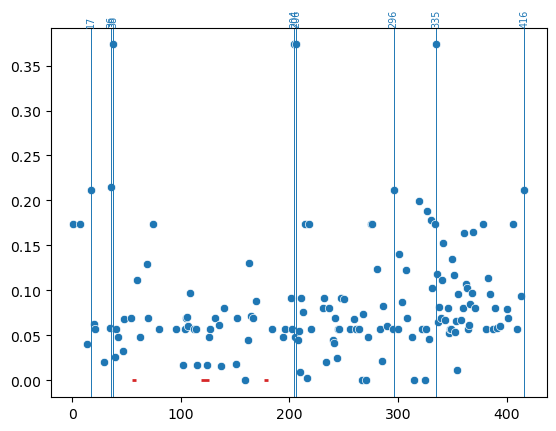

In [ ]:

fig, ax = plt.subplots()

# entropy = lambda probabilities : - sum([p * np.log2(p) for p in probabilities])

# probabilities = [[(column == aa).mean() for aa in column] for column in alignment.T]
# entropies = [entropy(p) for p in probabilities]
# sns.lineplot(x=np.arange(len(entropies)), y=entropies)

# probabilities = [[(column == aa).mean() for aa in column] for column in alignment[np.where(groups == True)].T]
# entropies = [entropy,(p) for p in probabilities]
# sns.lineplot(x=np.arange(len(entropies)), y=entropies)

# Want things for which the completeness score is zero, but the 
# scores = [adjusted_mutual_info_score(column, groups) for column in alignment.T]

domains = ['NIKS', 'Y.C...F', 'GGQ']


conserved = [np.all(column == column[0]) for column in alignment.T]
print('Num. completely conserved residues:', sum(conserved))
scores = [completeness_score(groups, column) for column in alignment.T] # The completeness score metric is not symmetric.
scores = np.where(conserved, np.nan, scores)

seqs =  [''.join(row) for row in alignment]
for domain in domains:
    matches = np.array([re.search(domain, seq) for seq in seqs])
    assert np.all([m is not None for m in matches]), 'Some sequences are missing critical domains.'
    start, end = matches[0].start(), matches[0].end()
    ax.hlines(0, xmin=start, xmax=end, color='tab:red', lw=2)

sns.scatterplot(x=np.arange(len(scores)), y=scores)
for i in np.where(scores > 0.2)[0]:
    ax.axvline(i, lw=0.7)
    ax.text(i, ax.get_ylim()[-1], str(i), va='bottom', ha='center', rotation=90, color='tab:blue', fontsize='x-small')

ax.set_title('aRF-1')
# Completeness score is 1 when all members of a class are in the same cluster. 

# In both prokaryotic and eukaryotic release factors (RFs), the N-terminal domain contains the 
# specific amino acid motifs that recognize and bind to the stop codon in the ribosomal A-site


In [81]:
''.join((alignment[np.where(groups == False)[0]][:, 36]))

# The N domain is responsible for stop codon recognition. Motifs include TASNIKS and YxCxxxF

'TDSDTD'

In [82]:
''.join((alignment[np.where(groups == True)[0]][:, 36]))

'TTDTTTTTDTTTTTTTTTNTTT'

In [9]:
FASTAFile('../data/ncbi/genomes/GCA_002505325.1.fn').to_df()
# ~/muscle5.1.linux_intel64 -align arf1.fa -output arf1.afa ous 

,description,seq
id,,
DAUV01000075.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,GATCAACGTGTTTACGTCGAGGGTCAAGAGGCTCTGGCAGTTTCTG...
DAUV01000089.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,GGAACGGAGGCTCTCAGCGTGGCGGATCGGCAGGATATAGTGAGCT...
DAUV01000031.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,CGAGCTCTCCAAGGCGGTCGCAGATATCATCGCCAGTGAGGTCAAC...
DAUV01000057.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,TCCGCGGCGTCCTCGGCCTCCTTACGGCGTCGCAGAATCTCAGGAC...
DAUV01000047.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,CCAAAAGAACAGCAGCGGGCGTGGCGCGTTGCGCGACCTCAGGGTG...
...,...,...
DAUV01000014.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,ACTTCGCATATGCTCAAAATGCAAAGGAGAATCATACAGAAGCCGG...
DAUV01000039.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,GAACCTGTCATCGGCCTGTGGTCCCGGGTCGACGGACATTCTCTTG...
DAUV01000081.1,MAG TPA_asm: Euryarchaeota archaeon UBA623 UBA...,GCTGTGAAATACGCAGACCTTTCTACAGAGAGGACGAAGGACTACG...
